In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoProcessor

In [2]:
processor = AutoProcessor.from_pretrained(
    pretrained_path="../tensorflow_tts/processor/pretrained/ljspeech_mapper.json"
)

In [3]:
input_text = "i love you so much."
input_ids = processor.text_to_sequence(input_text)

In [4]:
config = AutoConfig.from_pretrained("../examples/fastspeech2/conf/fastspeech2.v1.yaml")
fastspeech2 = TFAutoModel.from_pretrained(
    config=config, 
    pretrained_path=None, # "../examples/fastspeech2/checkpoints/model-150000.h5",
    is_build=True,
    name="fastspeech2"
)

# Save to Pb

In [5]:
mel_before, mel_after, duration_outputs, _, _ = fastspeech2.inference(
    input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
    speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
    speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    f0_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
    energy_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
)

In [6]:
fastspeech2.load_weights("../examples/fastspeech2/checkpoints/model-150000.h5")

In [7]:
# save model into pb and do inference. Note that signatures should be a tf.function with input_signatures.
tf.saved_model.save(fastspeech2, "./test_saved", signatures=fastspeech2.inference)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./test_saved/assets


# Load and Inference

In [8]:
fastspeech2 = tf.saved_model.load("./test_saved")

In [9]:
input_text = "There’s a way to measure the acute emotional intelligence that has never gone out of style."
input_ids = processor.text_to_sequence(input_text)

In [10]:
mel_before, mel_after, duration_outputs, _, _ = fastspeech2.inference(
    input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
    speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
    speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    f0_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
    energy_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32)
)

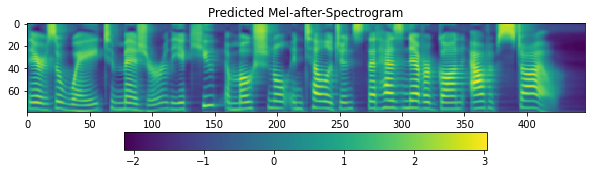

In [11]:
mel_after = tf.reshape(mel_after, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_after), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()

# Let inference other input to check dynamic shape

In [12]:
input_text = "The Commission further recommends that the Secret Service coordinate its planning as closely as possible with all of the Federal agencies from which it receives information."
input_ids = processor.text_to_sequence(input_text)

In [13]:
mel_before, mel_after, duration_outputs, _, _ = fastspeech2.inference(
    input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
    speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
    speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    f0_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
    energy_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32)
)

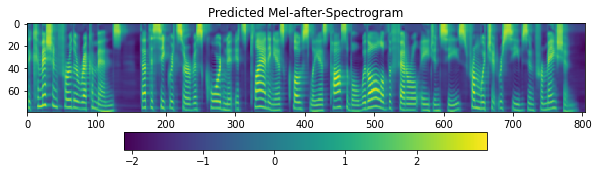

In [14]:
mel_after = tf.reshape(mel_after, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_after), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()